## Soft Actor-Critic: SAC in Pendulum

In [15]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  def __init__(self):
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
  
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
    
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    done = terminated or truncated
    self.step_n += 1
    if self.step_n >= 200:
      done = True
    return state, reward, done, info 
  
env = MyWrapper()
env.reset()

array([ 0.7815967 , -0.62378407, -0.6761425 ], dtype=float32)

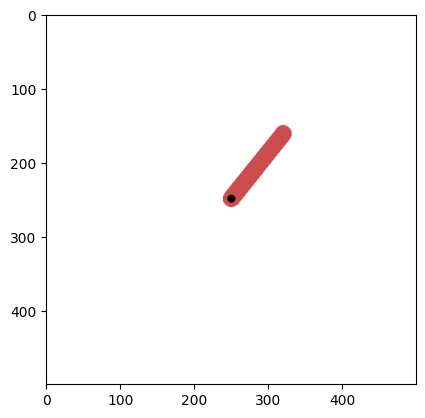

In [16]:
from matplotlib import pyplot as plt

%matplotlib inline

# 打印游戏
def show():
  plt.imshow(env.render())
  plt.show()
  
show()

In [17]:
import torch

# 定义模型
class ModelAction(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.fc_state = torch.nn.Sequential(
			torch.nn.Linear(3, 128),
			torch.nn.ReLU(),
		)
    
    self.fc_mu = torch.nn.Linear(128, 1)
    self.fc_std = torch.nn.Sequential(
			torch.nn.Linear(128, 1),
			torch.nn.Softplus(),
		)
    
  def forward(self, state):
    # [b, 3] -> [b, 128]
    state = self.fc_state(state)
    
    # [b, 128] -> [b, 1]
    mu = self.fc_mu(state)
    
    # [b, 128] -> [b, 1]
    std = self.fc_std(state)
    
    # 根据mu, std定义b个正态分布
    dist = torch.distributions.Normal(mu, std)
    
    # 采样b个样本
    # 这里用的是rsample,表示重采样,
    # 其实就是先从一个标准正态分布中采样,然后乘以标准差,加上均值
    sample = dist.rsample()
    
    # 样本压缩到-1,1之间，求动作
    action = torch.tanh(sample)
    
    # 求概率对数
    log_prob = dist.log_prob(sample)
    
    # 这个值描述动作的熵
    entropy = log_prob - (1 - action.tanh() ** 2 + 1e-7).log()
    entropy = - entropy
    
    return action * 2, entropy

model_action = ModelAction()

model_action(torch.randn(2, 3))

(tensor([[-1.8131],
         [ 1.3329]], grad_fn=<MulBackward0>),
 tensor([[0.1239],
         [1.2621]], grad_fn=<NegBackward0>))

In [18]:
class ModelValue(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.sequential = torch.nn.Sequential(
			torch.nn.Linear(4, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 1),
		)
    
  def forward(self, state, action):
    # [b, 3 + 1] -> [b, 4]
    state = torch.cat([state, action], dim=1)
    
    # [b, 4] -> [b, 1]
    return self.sequential(state)


model_value1 = ModelValue()
model_value2 = ModelValue()

model_value_next1 = ModelValue()
model_value_next2 = ModelValue()

model_value_next1.load_state_dict(model_value1.state_dict())
model_value_next2.load_state_dict(model_value2.state_dict())

model_value1(torch.randn(2, 3), torch.randn(2, 1))

tensor([[0.1632],
        [0.2217]], grad_fn=<AddmmBackward0>)

In [19]:
import random
import numpy as np 

# 得到一个动作
def get_action(state):
  # 走神经网络，得到一个动作
  state = torch.FloatTensor(state).reshape(1, 3)
  action, _ = model_action(state)
  return action.item()

get_action([1, 2, 3])

-1.2476619482040405

In [20]:
# 样本池
datas = []

def update_data():
  state = env.reset()
  
  # 玩到结束
  over = False
  while not over:
    action = get_action(state)
    
    next_state, reward, over, _ = env.step([action])
    
    datas.append((state, action, reward, next_state, over))
    
    state = next_state
    
  while len(datas) > 10000:
    datas.pop(0)
    
update_data()

len(datas), datas[0]

(200,
 (array([-0.27600995,  0.96115476, -0.0632143 ], dtype=float32),
  -0.6187177300453186,
  -3.4248981594729884,
  array([-0.3030414 ,  0.9529774 ,  0.56484413], dtype=float32),
  False))

In [21]:
# 获取一批数据样本
def get_sample():
  # 从样本池中采样
  samples = random.sample(datas, 64)
  
  # [b, 3]
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
  # [b, 1]
  action = torch.FloatTensor([i[1] for i in samples]).reshape(-1, 1)
  # [b, 1]
  reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
  # [b, 3]
  next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
  # [b, 1]
  over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)
  
  return state, action, reward, next_state, over

state, action, reward, next_state, over = get_sample()

state[:5], action[:5], reward[:5], next_state[:5], over[:5]

(tensor([[-0.7982,  0.6023,  3.3471],
         [-0.9969, -0.0788,  0.7452],
         [-0.7932, -0.6090,  1.3482],
         [-0.9924, -0.1234,  0.0771],
         [-0.8539,  0.5204, -2.3178]]),
 tensor([[-1.6147],
         [-1.3824],
         [-0.8090],
         [-1.5489],
         [ 1.5554]]),
 tensor([[-7.3487],
         [-9.4374],
         [-6.3668],
         [-9.1104],
         [-7.2699]]),
 tensor([[-0.8922,  0.4516,  3.5566],
         [-0.9947, -0.1027,  0.4787],
         [-0.7692, -0.6390,  0.7701],
         [-0.9938, -0.1111, -0.2478],
         [-0.8068,  0.5908, -1.6942]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0]]))

In [22]:
from IPython import display

def test(play):
  #初始化游戏
  state = env.reset()
  
  #记录反馈值的和,这个值越大越好
  reward_sum = 0
  
  #玩到游戏结束为止
  over = False
  while not over:
    #根据当前状态得到一个动作
    action = get_action(state)
    
    #执行动作,得到反馈
    state, reward, over, _ = env.step([action])
    reward_sum += reward
    
    # 打印动画
    if play and random.random() < 0.2: # 跳帧
      display.clear_output(wait=True)
      show()
      
  return reward_sum

test(play=False)

-1382.936360530765

In [23]:
def soft_update(model, model_next):
  for param, param_next in zip(model.parameters(), model_next.parameters()):
    # 小比例更新
    value = param_next.data * 0.995 + param.data * 0.005
    param_next.data.copy_(value)
    
soft_update(torch.nn.Linear(4, 64), torch.nn.Linear(4, 64))

In [24]:
import math

# 可学习参数
alpha = torch.tensor(math.log(0.01))
alpha.requires_grad = True

alpha

tensor(-4.6052, requires_grad=True)

In [25]:
def get_target(reward, next_state, over):
  # 首先使用model_action计算动作和动作的熵
  # [b, 3] -> [b, 1], [b, 1]
  action, entropy = model_action(next_state)
  
  # 评估next_state的价值
  # [b, 4], [b, 1] -> [b, 1]
  target1 = model_value_next1(next_state, action)
  target2 = model_value_next2(next_state, action)
  
  # 取价值小的，出于稳定性
  # [b, 1]
  target = torch.min(target1, target2)
  
  # 还原alpha
  # target 加上动作熵，alpha作为权重系数
  # [b, 1] - [b, 1] -> [b, 1]
  target += alpha.exp() * entropy
  
  # [b, 1] 
  target *= 0.99
  target *= (1 - over)
  target += reward
  
  return target

get_target(reward, next_state, over).shape

torch.Size([64, 1])

In [26]:
def get_loss_action(state):
	# 计算action和熵
	# [b, 3] -> [b, 1], [b, 1]
	action, entropy = model_action(state)

	# 使用两个value网络评估action的价值
	#[b, 3],[b, 1] -> [b, 1]
	value1 = model_value1(state, action)
	value2 = model_value2(state, action)

	# 取价值小的,出于稳定性考虑
	# [b, 1]
	value = torch.min(value1, value2)

	# alpha还原后乘以熵,这个值期望的是越大越好,但是这里是计算loss,所以符号取反
	# [1] - [b, 1] -> [b, 1]
	loss_action = -alpha.exp() * entropy
  
	# 减去value,所以value越大越好,这样loss就会越小
	loss_action -= value

	return loss_action.mean(), entropy

get_loss_action(state)

(tensor(-0.1200, grad_fn=<MeanBackward0>),
 tensor([[0.3246],
         [0.2849],
         [2.9171],
         [0.6608],
         [0.6094],
         [0.6170],
         [0.4520],
         [0.9625],
         [0.4627],
         [0.5246],
         [0.8586],
         [0.5969],
         [0.8905],
         [1.0649],
         [0.3295],
         [0.9705],
         [0.7470],
         [0.8180],
         [0.4797],
         [1.0617],
         [1.8362],
         [1.6010],
         [0.6076],
         [1.7960],
         [0.4299],
         [0.8737],
         [0.6102],
         [0.3741],
         [0.9156],
         [0.9290],
         [0.4875],
         [0.8953],
         [0.6804],
         [3.7379],
         [1.1271],
         [0.4343],
         [0.7882],
         [0.2557],
         [0.8297],
         [0.2646],
         [1.2123],
         [0.2456],
         [2.8014],
         [0.5856],
         [0.7515],
         [1.7529],
         [0.3800],
         [0.5936],
         [1.4304],
         [0.2900],
       

In [27]:
def train():
  optimizer_action = torch.optim.Adam(model_action.parameters(), lr=3e-4)
  optimizer_value1 = torch.optim.Adam(model_value1.parameters(), lr=3e-3)
  optimizer_value2 = torch.optim.Adam(model_value2.parameters(), lr=3e-3)
  
  # alpha 也要更新
  optimizer_alpha = torch.optim.Adam([alpha], lr=3e-4)
  
  loss_fn = torch.nn.MSELoss()
  
  # 玩N局游戏，每句游戏训练一次
  for epoch in range(100):
    # 更新N条数据
    update_data()
    
    # 每次更新过后，学习N次
    for i in range(200):
      # 采样一批数据
      state, action, reward, next_state, over = get_sample()
      
      # 对reward 偏移，便于训练
      reward = (reward + 8) / 8 
      
      # 计算value和target, target已经考虑了动作和熵
      # [b, 1]
      target = get_target(reward, next_state, over)
      target = target.detach()
      
      # 计算两个value
      value1 = model_value1(state, action)
      value2 = model_value2(state, action)
      
      # 计算两个loss,两个value的目标都是要贴近target
      loss_value1 = loss_fn(value1, target)
      loss_value2 = loss_fn(value2, target)
      
      # 更新参数
      optimizer_value1.zero_grad()
      loss_value1.backward()
      optimizer_value1.step()
      
      optimizer_value2.zero_grad()
      loss_value2.backward()
      optimizer_value2.step()
      
      # 使用model_value计算model_action的loss, 更新参数
      loss_action, entropy = get_loss_action(state)
      optimizer_action.zero_grad()
      loss_action.backward()
      optimizer_action.step()
      
      # 熵乘以alpha就是alpha的loss
      # [b, 1] -> [1]
      loss_alpha = (entropy + 1).detach() * alpha.exp()
      loss_alpha = loss_alpha.mean()
      
      # 更新alpha值
      optimizer_alpha.zero_grad()
      loss_alpha.backward()
      optimizer_alpha.step()
      
      # 小比例更新
      soft_update(model_value1, model_value_next1)
      soft_update(model_value2, model_value_next2)
      
    if epoch % 10 == 0:
      test_result = sum([test(play=False) for _ in range(10)]) / 10
      print(epoch, len(datas), alpha.exp().item(), test_result)
      
train()

0 400 0.009392817504703999 -1141.5906349283891
10 2400 0.005700817331671715 -1415.2724479062367
20 4400 0.0036922188010066748 -1225.0485882951084
30 6400 0.002197560155764222 -232.00750740014547
40 8400 0.0018453639931976795 -205.73016228564157
50 10000 0.0023835767060518265 -158.8075163819215
60 10000 0.004255387466400862 -194.9617557357606
70 10000 0.008861870504915714 -136.16699843842542
80 10000 0.018415069207549095 -157.46599463742544
90 10000 0.02513747289776802 -170.46528175559496


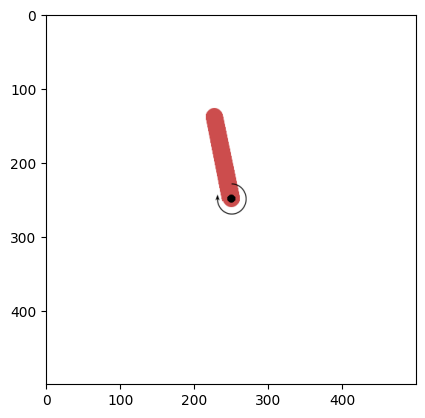

-133.78148801670076

In [28]:
test(play=True)